In [1]:
from ROOT import TFile, gDirectory
import ROOT as r
import os

Welcome to JupyROOT 6.16/00


In [2]:
%%time
#test if kernel is running

print('running')

running
CPU times: user 163 µs, sys: 92 µs, total: 255 µs
Wall time: 242 µs


# Todo

* Add plots for number of b-tagged jets
* Check number of jets
* extend MET plot range until no overflow 
* fix ratio scaling on log plots


* get total sum weight of all the files (>2) # of weighted entries
* [DONE] fix the loops so that there is only one and add a flag for data/mc to do the weighting 
* Create correction function of HT to get HT ratio ~1, make sure other rations remain unchanged, use tf1 fit or roofit
* evaluate function of HT by making ratio comparison plots for the mc original and mc corrected
* consider cutting off the function fit at certain HT value and flat after or adjusting bin sizes to reduce uncertainty, then fit 

Build files into TChain

In [3]:
%%time
filename = 'ttbar_nonallhad_HF_PhPy8_AFII_mc16a.root'
treename = 'nominal_Loose'

list_of_files = os.listdir('../data_ttbar/')
data_files = [f for f in list_of_files if 'data' in f]
mc_files = [ 'ttbar_nonallhad_incl_PhPy8_AFII_mc16a.root', 'ttbar_nonallhad_incl_PhPy8_AFII_mc16d.root','ttbar_nonallhad_incl_PhPy8_AFII_mc16e.root',
            'ttX_mc16e.root','ttX_mc16d.root','ttX_mc16a.root',
            'vjets_Sherpa_mc16e.root','vjets_Sherpa_mc16d.root', 'vjets_Sherpa_mc16a.root',
            'singleTop_mc16e.root','singleTop_mc16d.root','singleTop_mc16a.root',
            'multiV_mc16a.root','multiV_mc16d.root','multiV_mc16e.root']

#data_files = ['data15_AllYear.root']
#mc_files = ['ttbar_nonallhad_HF_PhPy8_AFII_mc16d.root']

data_chain = r.TChain(treename)
mc_chain = r.TChain(treename)

for f in data_files:
    data_chain.Add('../data_ttbar/'+f)
for f in mc_files:
    mc_chain.Add('../data_ttbar/'+ f)

data_entries = data_chain.GetEntries()
mc_entries = mc_chain.GetEntries()

print(f'There are {data_entries} data events and {mc_entries} mc events')



There are 3223533 data events and 23130773 mc events
CPU times: user 213 ms, sys: 35.5 ms, total: 248 ms
Wall time: 274 ms


In [4]:
#use lum = 140
def GetWeight(lumi,tree, corr_poly = None):
    #w = lumi * 1000 * tree.weight_normalise *  tree.weight_mc *  tree.weight_pileup *tree.weight_leptonSF *  tree.weight_bTagSF_MV2c10_77 *  tree.weight_jvt
    w = ((43.5938/127.64416)*(tree.runNumber == 300000)+(36.20766/127.64416)*(tree.runNumber == 284500)+(47.8427/127.64416)*(tree.runNumber == 310000))*tree.weight_normalise*tree.weight_mc*tree.weight_pileup*tree.weight_leptonSF*tree.weight_bTagSF_MV2c10_77*127.65516*1000*(tree.nBTags_MV2c10_77>1)
    
    if corr_poly:
        w_ht_corrected = w / corr_poly.Eval(tree.HT_all)
        return w_ht_corrected
   
    else: return w

def poly_ht(func, ht):
    pol =  func.Parameter(0) + func.Parameter(1)*ht + func.Parameter(2)* ht**2 + func.Parameter(3)* ht**3 + func.Parameter(4) * ht**4 + func.Parameter(5)*ht**5
    return pol

Initialize histograms

In [5]:
%%time
#####
#Set Up Code
#####

met_mc = r.TH1D('met_mc', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_mc_corr = r.TH1D('met_mc_corr', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_data = r.TH1D('met_data', 'E^T_{miss}', 100, 0, 1.2*10**6)

jet_pt_data = r.TH1D('jet_pt_data', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_mc = r.TH1D('jet_pt_mc', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_mc_corr = r.TH1D('jet_pt_mc_corr', 'jet_{pt}', 100, 0, 2*10**6)

mu_pt_mc = r.TH1D('mu_pt_mc', '\mu_{pt}', 100, 0, 1000*10**3)
mu_pt_mc_corr = r.TH1D('mu_pt_mc_corr', '\mu_{pt}', 100, 0, 1000*10**3)
mu_pt_data = r.TH1D('mu_pt_data', '\mu_{pt}', 100, 0, 1000*10**3)

ht_all_mc = r.TH1D('ht_all_mc', 'H_{t}', 100, 0, 6000*10**3)
ht_all_mc_corr = r.TH1D('ht_all_mc_corr', 'H_{t}', 100, 0, 6000*10**3)
ht_all_data = r.TH1D('ht_all_data', '\H_{t}', 100, 0, 6000*10**3)

bjets_mc = r.TH1D('bjets_mc', 'Number of B Jets', 7,0,7)
bjets_mc_corr = r.TH1D('bjets_mc_corr', 'Number of B Jets', 7,0,7)
bjets_data = r.TH1D('bjets_data', 'Number of B Jets', 7,0,7)



CPU times: user 21.4 ms, sys: 2.76 ms, total: 24.2 ms
Wall time: 26.9 ms


Fill histograms

In [6]:
%%time
def fill_hists(chain, entries, data, poly= None):
    
    for jentry in range(entries):
        nb = chain.GetEntry(jentry)
    
        if nb<=0: continue
        
        jet_pt = chain.jet_pt[0]
        met = chain.met_met
        #mu_pt = mc_chain.mu_pt
        ht_all = chain.HT_all
        bjets_mc70 = chain.nBTags_MV2c10_70

        #add conditions here
        if (bjets_mc70 < 2): continue
        
        if data: 
            met_data.Fill(met)
            jet_pt_data.Fill(jet_pt)
            #mu_pt_data.Fill(mu_pt)
            ht_all_data.Fill(ht_all)
            bjets_data.Fill(bjets_mc70)
        

        elif poly:
            weight = GetWeight(140, chain, corr_poly = poly)
            met_mc_corr.Fill(met,weight)

            jet_pt_mc_corr.Fill(jet_pt, weight)
            #mu_pt_mc.Fill(mu_pt, weight)
            ht_all_mc_corr.Fill(ht_all, weight)
            bjets_mc_corr.Fill(bjets_mc70, weight)
            
        else:
            weight = GetWeight(140, chain)
            met_mc.Fill(met,weight)

            jet_pt_mc.Fill(jet_pt, weight)
            #mu_pt_mc.Fill(mu_pt, weight)
            ht_all_mc.Fill(ht_all, weight)
            bjets_mc.Fill(bjets_mc70, weight)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


In [29]:
def make_ratio_hists(mc_hist, data_hist, save_name, draw = True , log = False):
    c = r.TCanvas()
    
    rp = r.TRatioPlot(mc_hist, data_hist)
    rp.Draw()

    if log == True:
        c.SetLogy(1)
    lower_y = rp.GetLowerRefYaxis()
    
    lower_y.SetTitle('MC/Data')
    lower_y.SetRangeUser(0,2)

    if draw == True:
        c.Draw()
        
    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def make_ratio_compare_hists(mc_original, mc_corr_original, data, save_name, draw = True):
    
    c = r.TCanvas()
        
    mc = mc_original.Clone()
    mc_corr = mc_corr_original.Clone()
    
    mc.Divide(data)
    mc_corr.Divide(data)
    
    mc_corr.SetLineColor(4)
    mc_corr.Draw()
    mc.SetLineColor(2)
    mc.Draw("SAME")
    
    if draw== True:
        c.Draw()

    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def test_corr_fn(data_chain, mc_chain):
    fill_hists(data_chain, 1000, data= True, poly = None)
    fill_hists(mc_chain, 1000, data= False, poly = None)
    
    #clone ht_all, call divide from data, fit divided, pass fn to corr_hists
    ht_ratio = ht_all_mc.Clone()
    
    ht_ratio.Divide(ht_all_data)
    
    ht_ratio.Fit('pol5','S')
    
    ht_fit = ht_ratio.GetFunction('pol5')
    
    
    fill_hists(mc_chain, 1000, data = False, poly = ht_fit)
    
    

In [9]:
%%time
test_corr_fn(data_chain, mc_chain)

CPU times: user 372 ms, sys: 72.6 ms, total: 445 ms
Wall time: 457 ms

****************************************
Minimizer is Linear
Chi2                      =      10.4216
NDf                       =           16
p0                        =    -0.185008   +/-   0.378485    
p1                        =   4.1036e-06   +/-   3.73549e-06 
p2                        = -1.38568e-11   +/-   1.32317e-11 
p3                        =  2.16649e-17   +/-   2.11024e-17 
p4                        = -1.57839e-23   +/-   1.52746e-23 
p5                        =  4.25779e-30   +/-   4.06328e-30 


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [30]:
make_ratio_compare_hists(jet_pt_mc, jet_pt_mc_corr, jet_pt_data,'jet_pt_ratio', draw=False)
make_ratio_compare_hists(met_mc, met_mc_corr, met_data,'met_ratio', draw=False)
make_ratio_compare_hists(ht_all_mc, ht_all_mc_corr, ht_all_data,'ht_all_ratio', draw=False)
make_ratio_compare_hists(bjets_mc, bjets_mc_corr, bjets_data,'bjets_ratio', draw=False)

Info in <TCanvas::SaveAs>: ROOT file jet_corr_test4.root has been created


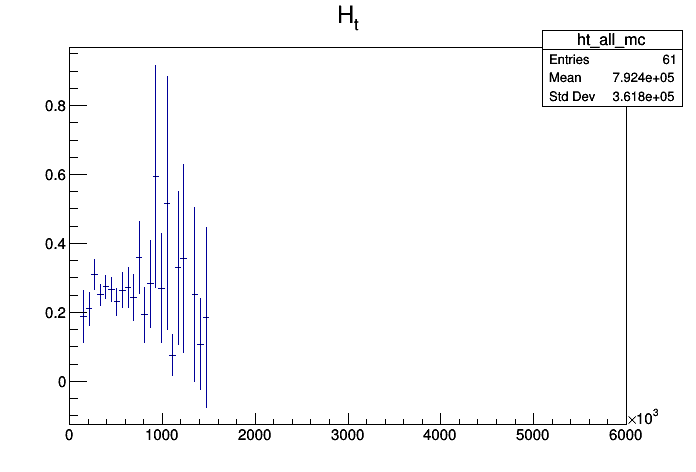

In [11]:
c_corr = r.TCanvas()


ht_ratio = ht_all_mc.Clone()
    
ht_ratio.Divide(ht_all_data)
        
ht_ratio.Draw()
    
c_corr.Draw()

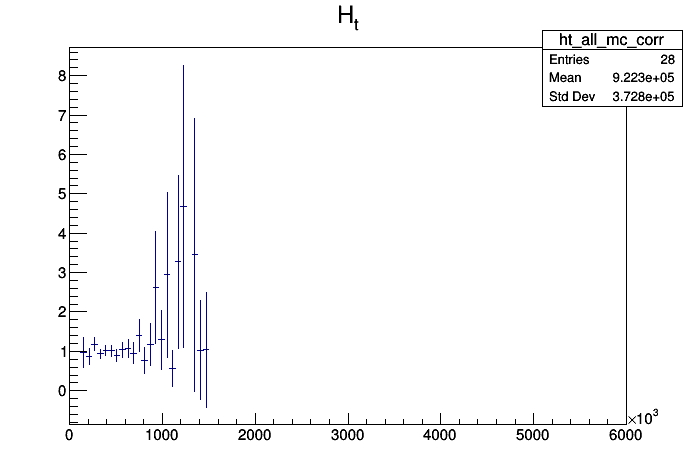

In [13]:
c_c = r.TCanvas()


ht_ratio_corr = ht_all_mc_corr.Clone()
    
ht_ratio_corr.Divide(ht_all_data)
        
ht_ratio_corr.Draw()
    
c_c.Draw()

In [8]:
%%time
fill_hists(data_chain, 10, data= True, poly = None)

CPU times: user 37 ms, sys: 6.6 ms, total: 43.6 ms
Wall time: 47.1 ms


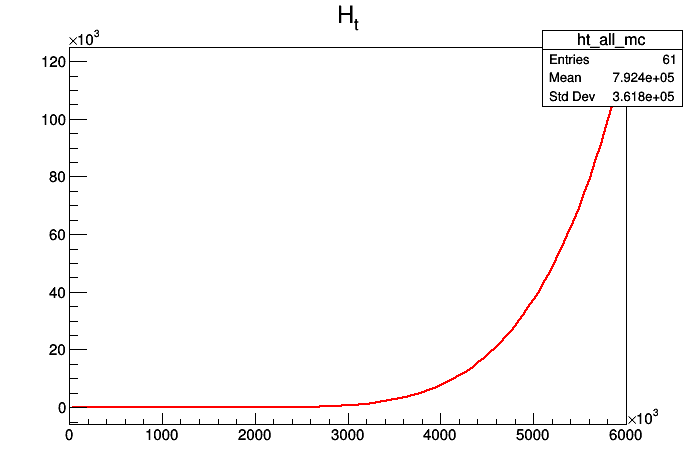

In [10]:
c2 = r.TCanvas()
ht_all_mc.Draw()
c2.Draw()

In [9]:
%%time
fill_hists(mc_chain, 10, data = False, poly = None)

CPU times: user 22.5 ms, sys: 4.76 ms, total: 27.3 ms
Wall time: 30.5 ms


# Plot and draw settings

## Jet pt

CPU times: user 138 ms, sys: 28.8 ms, total: 167 ms
Wall time: 256 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 30 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file jet_pt_ttbar.root has been created


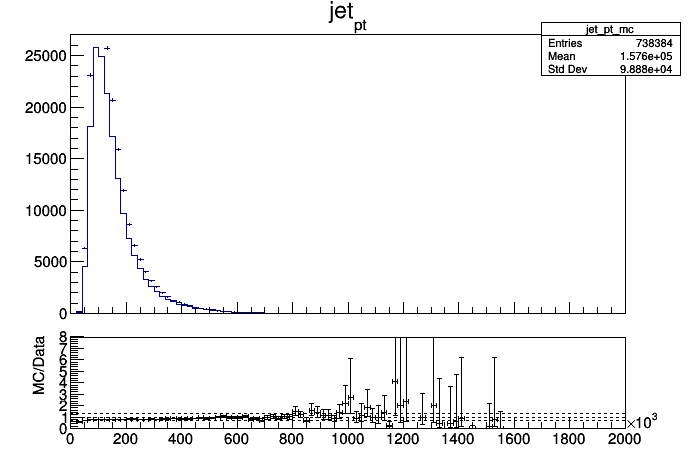

In [9]:
%%time
###
#Wrap Up
####
c_jet_pt = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_jet_pt = r.TRatioPlot(jet_pt_mc, jet_pt_data)
rp_jet_pt.Draw()
jet_pt_upper_pad = rp_jet_pt.GetUpperPad()

lower_y_jetpt = rp_jet_pt.GetLowerRefYaxis()
rp_jet_pt.GetLowerPad().SetLogy(0)
lower_y_jetpt.SetTitle('MC/Data')
lower_y_jetpt.SetRangeUser(0,8)


c_jet_pt.Draw()
c_jet_pt.SaveAs('jet_pt_ttbar.root')

# ht 

CPU times: user 84.4 ms, sys: 41.5 ms, total: 126 ms
Wall time: 224 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 46 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file ht_all_ttbar.root has been created


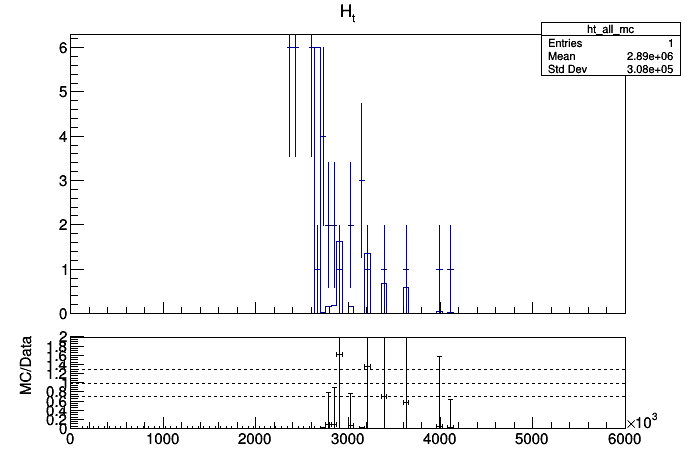

In [19]:
%%time
###
#Wrap Up
####
c_ht = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_ht = r.TRatioPlot(ht_all_mc, ht_all_data)
rp_ht.Draw()
#ht_upper_pad = rp_ht.GetUpperPad()
#ht_log_upper_pad.SetLogy(1)
lower_y_ht_log = rp_ht.GetLowerRefYaxis()
#rp_ht.GetLowerPad().SetLogy(0)
lower_y_ht_log.SetTitle('MC/Data')
lower_y_ht_log.SetRangeUser(0,2)


c_ht.Draw()
c_ht.SaveAs('ht_all_ttbar.root')

## met

CPU times: user 8.25 ms, sys: 2.38 ms, total: 10.6 ms
Wall time: 11.1 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 35 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file met_ttbar.root has been created


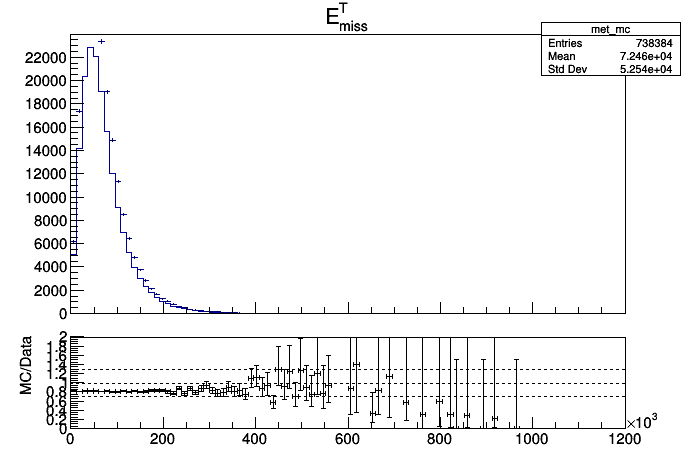

In [14]:
%%time
###
#Wrap Up
####
c_met = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_met = r.TRatioPlot(met_mc, met_data)
rp_met.Draw()
met_upper_pad = rp_met.GetUpperPad()
#met_upper_pad.SetLogy(1)
lower_y_met = rp_met.GetLowerRefYaxis()
#rp_met.GetLowerPad().SetLogy(0)
lower_y_met.SetTitle('MC/Data')
lower_y_met.SetRangeUser(0,2)


c_met.Draw()
c_met.SaveAs('met_ttbar.root')

## bjets

CPU times: user 7.64 ms, sys: 1.91 ms, total: 9.56 ms
Wall time: 11.2 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 3 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file bjets_bjets3.root has been created


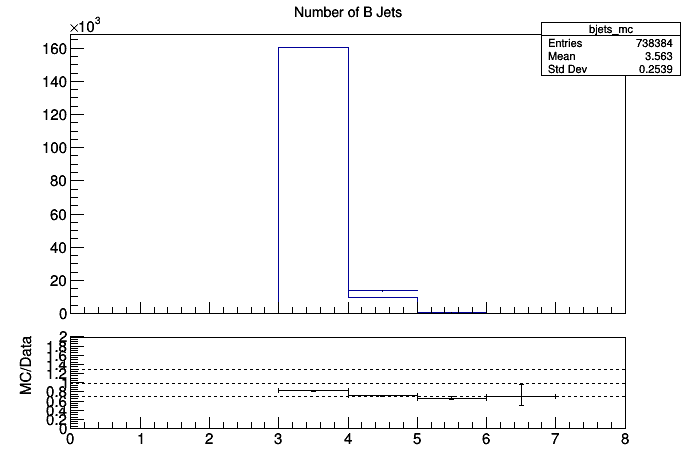

In [15]:
%%time
###
#Wrap Up
####
c_bjets = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_bjets = r.TRatioPlot(bjets_mc, bjets_data)
rp_bjets.Draw()

lower_y_bjets = rp_bjets.GetLowerRefYaxis()
#rp_met.GetLowerPad().SetLogy(0)
lower_y_bjets.SetTitle('MC/Data')
lower_y_bjets.SetRangeUser(0,2)


c_bjets.Draw()
c_bjets.SaveAs('bjets_bjets3.root')

In [39]:
make_ratio_hists(met_mc, met_data, 'met_test', draw=True)

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 94 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file met_test.root has been created


CPU times: user 91 ms, sys: 27.9 ms, total: 119 ms
Wall time: 125 ms


Info in <TCanvas::SaveAs>: ROOT file ht_correction_other.root has been created


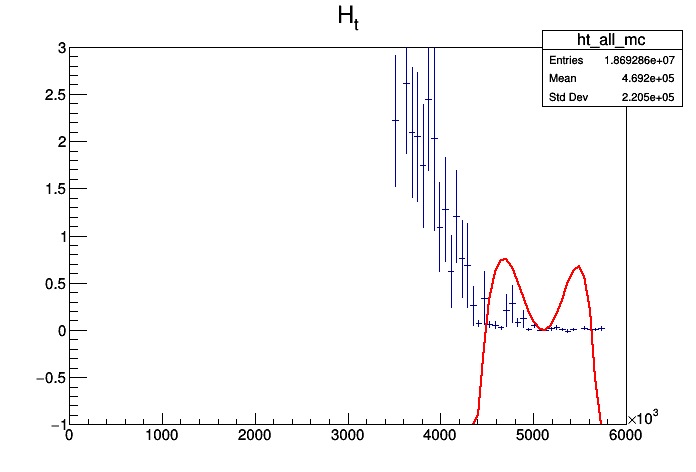

In [11]:
%%time
###
#Wrap Up
####
c_ht_corr = r.TCanvas()

#ht_all_mc.Sumw2()
#ht_all_data.Sumw2()


#ht_all_mc.Divide(ht_all_data)

ht_all_mc.Draw()
ht_all_mc.GetYaxis().SetRangeUser(-1,3)
c_ht_corr.Draw()
c_ht_corr.SaveAs('ht_correction_other.root')


****************************************
Minimizer is Linear
Chi2                      =  7.24726e+06
NDf                       =           88
p0                        =      26745.8   +/-   29.5963     
p1                        =   -0.0300952   +/-   3.50378e-05 
p2                        =  1.33348e-08   +/-   1.63844e-11 
p3                        = -2.91605e-15   +/-   3.7733e-18  
p4                        =  3.15339e-22   +/-   4.28153e-25 
p5                        = -1.35105e-29   +/-   1.91741e-32 


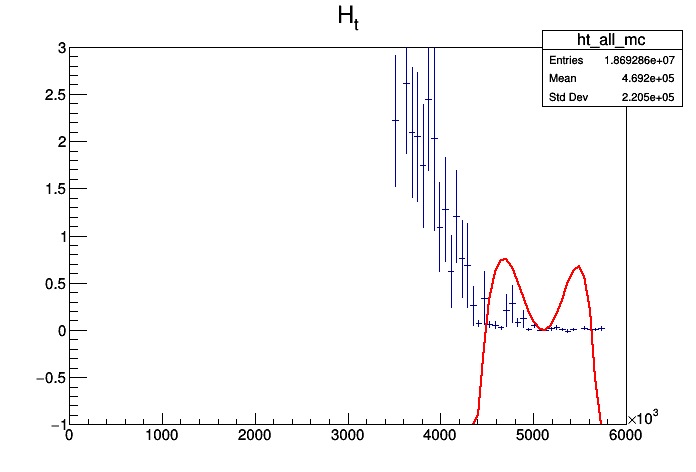

In [12]:
t_fit = ht_all_mc.Fit('pol5', 'S')
ht_all_mc.Draw()
c_ht_corr.Draw()

In [16]:
test_f = ht_all_mc.GetFunction("pol5")

test_f.Eval(1000)

26715.727693224253

In [16]:
l =  ht_all_mc.GetListOfFunctions()
print(l[0].name)

AttributeError: 'TPaveStats' object has no attribute 'name'

In [23]:
plot_file = r.TFile('ht_correction.root')
ht_all = plot_file.Get("c1")
ht_ratio = ht_all.GetPrimitive('ht_all_mc')
ht_ratio.Draw()

In [1]:
%%time
for jentry in range(data_entries):
    nb = data_chain.GetEntry(jentry)
    
    if nb<=0: continue
        
    #add requirement for >2 b tag jets 
    
    jet_pt = data_chain.jet_pt[0]
    met = data_chain.met_met
    
    #mu_pt = data_chain.mu_pt

    ht_all = data_chain.HT_all
    bjets_mc70 = data_chain.nBTags_MV2c10_70
    
        
    #add conditions here
    if (bjets_mc70 < 3): continue

    met_data.Fill(met)
    jet_pt_data.Fill(jet_pt)
    #mu_pt_data.Fill(mu_pt)
    ht_all_data.Fill(ht_all)
    bjets_data.Fill(bjets_mc70)


NameError: name 'data_entries' is not defined

In [6]:
%%time
for jentry in range(mc_entries):
    nb = mc_chain.GetEntry(jentry)
    
    if nb<=0: continue
        
    jet_pt = mc_chain.jet_pt[0]
    met = mc_chain.met_met
    #mu_pt = mc_chain.mu_pt
    ht_all = mc_chain.HT_all
    bjets_mc70 = mc_chain.nBTags_MV2c10_70
    
    #add conditions here
    if (bjets_mc70 < 3): continue
    
    
    weight = GetWeight(140, mc_chain)

    met_mc.Fill(met,weight)
    
    jet_pt_mc.Fill(jet_pt, weight)
    #mu_pt_mc.Fill(mu_pt, weight)
    ht_all_mc.Fill(ht_all, weight)
    bjets_mc.Fill(bjets_mc70, weight)
    


KeyboardInterrupt: 

dont mix HF with inc

v is vector boston

ttX is maybe tt +W,Z

plot on logy scale and test that 